In [1]:
%run 0_data_model.ipynb

In [2]:
pk_str = ["calitp_itp_id", "calitp_url_number"]
pk_col = (_.calitp_itp_id, _.calitp_url_number)

DATE_START = "2021-04-01"
DATE_END = "2021-05-01"

from siuba.siu import symbolic_dispatch
from siuba.sql.dialects.bigquery import BigqueryColumn
from sqlalchemy import sql

@symbolic_dispatch(cls=BigqueryColumn)
def str_format(col, fmt) -> BigqueryColumn:
    return sql.func.format(fmt, col)

@symbolic_dispatch(cls=BigqueryColumn)
def as_time(col, fmt=None) -> BigqueryColumn:
    return sql.func.parse_time(fmt or "%T", col)

@symbolic_dispatch(cls=BigqueryColumn)
def time_diff(x, y, unit) -> BigqueryColumn:
    return sql.func.time_diff(x, y, sql.text(unit))


In [4]:
# Main tables defined ------------

extract_hour = lambda colname: sql_raw('REGEXP_EXTRACT(%s, "([0-9]*?):")' % colname)

hour_extracted = tbl_stops_and_times >> mutate(
    arrival_hour=extract_hour("arrival_time"),
    departure_hour=extract_hour("departure_time"),
)

(
    hour_extracted
    >> summarize(
        max_hour=_.arrival_hour.astype(int).max(),
        departure_hour=_.departure_hour.astype(int).max(),
    )
    >> collect()
)

from siuba.dply.vector import lag

# Create new time columns to track hour number, as well as converting
# times like 25:00:00 to 1:00:00
stop_times_fixed = (
    hour_extracted
    >> mutate(
        stop_sequence = _.stop_sequence.astype(int),
        arrival_hour_24=(_.arrival_hour.astype(int) % 24).astype(str),
        departure_hour_24=(_.departure_hour.astype(int) % 24).astype(str),
        new_arrival_time=as_time(_.arrival_time.str.replace("^([0-9]*?):", _.arrival_hour_24 + ":")),
        new_departure_time=as_time(_.departure_time.str.replace("^([0-9]*?):", _.departure_hour_24 + ":"))
    )
)

# this expression infers when an arrival time is after midnight, by checking one of these holds..
# * explicitly encoded
#   - departure hour coded as >= 24 (e.g. 24:00:00)
#   - or, arrival hour coded as > 24
# * implicitly coded
#   - previous departure is later than 22:00 (assuming transit times are < 2 hours)
#   - and, it's an earlier time than previous departure (e.g. departed 23:50, arrived 00:10)
# * it's after a stop time that met the above criteria
expr_after_midnight = (
    (_.departure_hour.astype(int) >= 24)
    | (_.arrival_hour.astype(int) > 24)
    | ((_.prev_departure > "22:00:00") & (_.new_arrival_time < _.prev_departure))
).fillna(False).astype(int).cumsum() >= 1


stop_times_enhanced = (
    stop_times_fixed
    >> group_by(*pk_col, _.trip_id)
    >> arrange(_.stop_sequence)
    >> mutate(
        prev_departure=lag(_.new_departure_time),
        arrives_after_midnight=expr_after_midnight,
        # if arrival is after midnight, need to add a days worth of seconds
        # to the time diff, to account for e.g. 00:00 - 23:50 being negative
        n_transit_seconds_raw=(
            time_diff(_.new_arrival_time, _.prev_departure, "SECOND")
        ),
        n_transit_seconds=if_else(_.n_transit_seconds_raw < 0, _.n_transit_seconds_raw + (60 * 60 * 24), _.n_transit_seconds_raw),
        ttl_transit_seconds=_.n_transit_seconds.cumsum(),
    )
    >> ungroup()
)

* 30:01:01 is not a time in most data systems
* we may want to know which times occur after midnight

## Motivating Cases

## Modelling time in transit, midnight switchpoint

### Maximum hour part in stop_times data

### Converting to a TIME type

In [5]:
fix_hour = str_format(_.arrival_hour.astype(int) % 24, "%02d")

df_hour_counts = (hour_extracted >> 
  count(_.arrival_hour, new_arrival_hour = fix_hour)
  >> collect()
  >> arrange(_.arrival_hour)
)

with pd.option_context("display.max_rows", 999):
    display(df_hour_counts >> filter(_.arrival_hour != _.new_arrival_hour))

,arrival_hour,new_arrival_hour,n
41,0,00,277
40,1,01,318
39,2,02,318
20,24,00,60521
22,25,01,35024
26,26,02,24413
27,27,03,19963
29,28,04,14184
32,29,05,5267
38,3,03,487


### Augmenting to indicate when stop times are after midnight

* is_midnight_point
* arrives_after_midnight

In [6]:
stop_times_enhanced >> count(_.arrives_after_midnight)

,arrives_after_midnight,n
0,False,9417497
1,True,161528


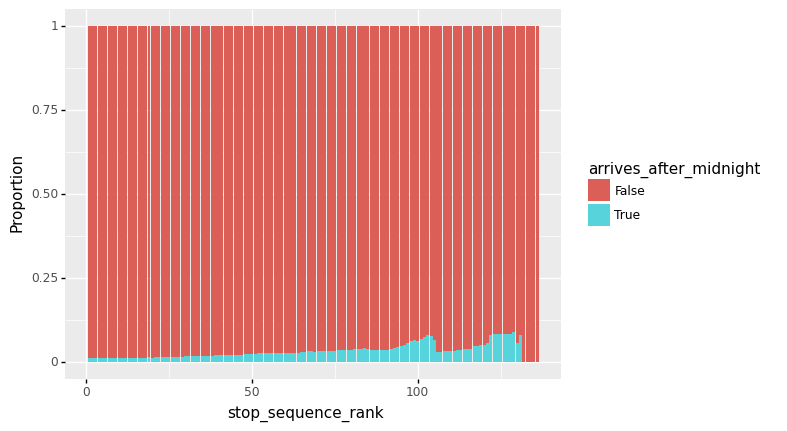

<ggplot: (317711680)>

In [7]:
from plotnine import *

(
    stop_times_enhanced
    >> count(_.arrives_after_midnight, _.stop_sequence_rank)
    >> collect()
    >> group_by(_.stop_sequence_rank)
    >> mutate(prop = _.n / _.n.sum())
    >> ungroup()
    >> ggplot(aes("stop_sequence_rank", "prop", fill="arrives_after_midnight"))
#    + facet_wrap("~arrives_after_midnight")
    + geom_col()
    + labs(y = "Proportion")
)

## Edge cases: trips beginning at or after midnight

Trips can begin after midnight. As far as I can tell, what this means is that a trip reported as being in service on, e.g., a Monday is actually scheduled for Tuesday morning. I have no idea why this happens, but would imagine it's because either:

* some agencies schedule by route (i.e. batches of trips).
* some agencies prefer in cases to present it like this to users (e.g. a Monday route service with a 2am trip matches a "waking day").

Below is a count of trips starting at or after midnight:

In [8]:
midnight_edge_cases = (
    stop_times_enhanced
    >> filter(_.arrival_hour.astype(int) >= 24, _.departure_hour.astype(int) >= 24)
    >> select(
        _.calitp_itp_id,
        _.calitp_url_number,
        _.trip_id,
        _.stop_id,
        _.stop_sequence_rank,
        _.contains("time"),
        _.prev_departure,
        _.arrives_after_midnight,
        _.arrival_hour
    )
)

(
    midnight_edge_cases
    >> filter(_.stop_sequence_rank == 1)
    >> count()
    >> collect()
)

,n
0,2746


### Case 1: trips that left exactly at midnight

One maybe ambiguous case is when a trip leaves at midnight. This is shown for one specific trip below.

In [9]:
(
    midnight_edge_cases
    >> filter(_.calitp_itp_id == 4, _.calitp_url_number == 0, _.trip_id == "6855070")
    >> collect()
    >> head()
    >> arrange(_.stop_sequence_rank)
)

,calitp_itp_id,calitp_url_number,trip_id,stop_id,stop_sequence_rank,arrival_time,departure_time,timepoint,stop_timezone,new_arrival_time,new_departure_time,prev_departure,arrives_after_midnight,arrival_hour
0,4,0,6855070,5654,1,24:00:00,24:00:00,1,None,00:00:00,00:00:00,None,True,24
1,4,0,6855070,254,2,24:00:06,24:00:06,0,None,00:00:06,00:00:06,00:00:00,True,24
2,4,0,6855070,233,3,24:00:52,24:00:52,0,None,00:00:52,00:00:52,00:00:06,True,24
3,4,0,6855070,229,4,24:01:00,24:01:00,1,None,00:01:00,00:01:00,00:00:52,True,24
4,4,0,6855070,236,5,24:01:29,24:01:29,0,None,00:01:29,00:01:29,00:01:00,True,24


Note that in the table above, the trip leaves exactly at midnight (shown by a departure time of `24:00:00` in the first row).

### Case 2: trips leaving hours after midnight

While it could be argued for the case above that the current day should include `24:00:00`, other trips are coded as starting after 24:00:00 (e.g. 25:00:00). These cases are problematic, since they're being described under the service schedule for the wrong day.

It could be interpreted as follows:

* The Mission route will be in service Monday, with a trip leaving at 2am Tuesday.

In [10]:
(
    midnight_edge_cases
    >> filter(_.stop_sequence_rank == 1, _.arrival_hour.astype(int) >= 25)
    >> inner_join(_, tbl_agency_trips, [*pk_str, "trip_id"])
    >> select(
        _.calitp_itp_id,
        _.calitp_url_number,
        _.route_long_name,
        _.arrival_time,
        _.departure_time,
        _.contains(""),
    )
)

,calitp_itp_id,calitp_url_number,route_long_name,arrival_time,departure_time,trip_id,stop_id,stop_sequence_rank,timepoint,stop_timezone,new_arrival_time,new_departure_time,prev_departure,arrives_after_midnight,arrival_hour,agency_url,route_type,route_color,agency_id,calitp_extracted_at,direction_id,shape_id,agency_timezone,wheelchair_accessible,calitp_extracted_at_y,route_short_name,agency_fare_url,agency_phone,trip_short_name,agency_lang,route_desc,route_text_color,bikes_allowed,calitp_extracted_at_x,agency_email,continuous_pickup,route_url,agency_name,block_id,service_id,trip_headsign,continuous_drop_off,route_sort_order,route_id
0,282,0,MISSION,25:00:00,25:00:00,9752397,6498,1,None,None,01:00:00,01:00:00,None,True,25,https://SFMTA.com,3,,SFMTA,2021-04-16,0,184123,America/Los_Angeles,None,2021-04-16,14,None,None,None,en,,,None,2021-04-16,None,None,https://SFMTA.com/14,San Francisco Municipal Transportation Agency,1493,1,Daly City,None,None,16283
1,282,0,MISSION,27:30:00,27:30:00,9752362,6498,1,None,None,03:30:00,03:30:00,None,True,27,https://SFMTA.com,3,,SFMTA,2021-04-16,0,184123,America/Los_Angeles,None,2021-04-16,14,None,None,None,en,,,None,2021-04-16,None,None,https://SFMTA.com/14,San Francisco Municipal Transportation Agency,1496,1,Daly City,None,None,16283
2,282,0,MISSION,29:00:00,29:00:00,9752356,6498,1,None,None,05:00:00,05:00:00,None,True,29,https://SFMTA.com,3,,SFMTA,2021-04-16,0,184123,America/Los_Angeles,None,2021-04-16,14,None,None,None,en,,,None,2021-04-16,None,None,https://SFMTA.com/14,San Francisco Municipal Transportation Agency,1493,1,Daly City,None,None,16283
3,282,0,MISSION,27:00:00,27:00:00,9752364,6498,1,None,None,03:00:00,03:00:00,None,True,27,https://SFMTA.com,3,,SFMTA,2021-04-16,0,184123,America/Los_Angeles,None,2021-04-16,14,None,None,None,en,,,None,2021-04-16,None,None,https://SFMTA.com/14,San Francisco Municipal Transportation Agency,1493,1,Daly City,None,None,16283
4,282,0,MISSION,26:30:00,26:30:00,9752366,6498,1,None,None,02:30:00,02:30:00,None,True,26,https://SFMTA.com,3,,SFMTA,2021-04-16,0,184123,America/Los_Angeles,None,2021-04-16,14,None,None,None,en,,,None,2021-04-16,None,None,https://SFMTA.com/14,San Francisco Municipal Transportation Agency,1495,1,Daly City,None,None,16283


## Quality check: trips with negative transit time

One issue

In [11]:
qa_neg_transit_time = (
    stop_times_enhanced
    >> filter(_.n_transit_seconds_raw < 0)
    >> inner_join(_, tbl_agency_trips, [*pk_str, "trip_id"])    
    >> select(
        _.calitp_itp_id,
        _.calitp_url_number,
        _.trip_id,
        _.route_long_name,
        _.prev_departure,
        _.contains("time"),
        _.stop_sequence_rank,
        _.arrives_after_midnight,
        _.contains("n_transit_seconds")
    )
)

### Range of negative times

Basically, we don't want these times to be less that 60 seconds * 60 minutes * 24 hours = 86400.

In [12]:
(
    qa_neg_transit_time
    >> select(*pk_col, _.trip_id, _.n_transit_seconds_raw)
    >> summarize(
        neg_transit_sec_min=_.n_transit_seconds_raw.min(),
        neg_transit_sec_max=_.n_transit_seconds_raw.max(),
    )
)

,neg_transit_sec_min,neg_transit_sec_max
0,-86383,-7200


## Which trip has the most service hours?

Looks like a paratransit bus, called dial-a-ride from Tulare County Area Transit.

In [14]:
(
    stop_times_enhanced
    >> filter(_.n_transit_seconds == _.n_transit_seconds.max())
    >> select(_.calitp_itp_id, _.calitp_url_number, _.trip_id, _.ttl_transit_seconds)
    >> mutate(ttl_transit_hours = _.ttl_transit_seconds // 3600)
    >> inner_join(_, tbl_agency_trips, [*pk_str, "trip_id"])
)

,calitp_itp_id,calitp_url_number,trip_id,ttl_transit_seconds,ttl_transit_hours,agency_url,route_type,route_color,agency_id,calitp_extracted_at,direction_id,route_long_name,shape_id,agency_timezone,wheelchair_accessible,calitp_extracted_at_y,route_short_name,agency_fare_url,agency_phone,trip_short_name,agency_lang,route_desc,route_text_color,bikes_allowed,calitp_extracted_at_x,agency_email,continuous_pickup,route_url,agency_name,block_id,service_id,trip_headsign,continuous_drop_off,route_sort_order,route_id
0,346,0,t_554230_b_17398_tn_0,79200,22.0,http://tularecounty.ca.gov/rma/index.cfm/public-works/tulare-county-area-transit-tcat/,3,None,937,2021-04-29,0,Dial-a-Ride,None,America/Los_Angeles,None,2021-04-29,None,http://www.tularecounty.ca.gov/rma/index.cfm/public-works/tulare-county-area-transit-tcat/tcat-systemwide-area-map/,877-404-6473,None,en,None,None,None,2021-04-29,None,1,None,Tulare County Area Transit,None,c_15968_b_17398_d_31,None,1,9,12496


### How long do trips tend to be?

In [15]:
transit_minutes = (
    stop_times_enhanced
    >> group_by(_.calitp_itp_id, _.calitp_url_number, _.trip_id)
    >> filter(_.stop_sequence_rank == _.stop_sequence_rank.max())
    >> ungroup()
    >> select(*pk_col, _.trip_id, _.ttl_transit_seconds, _.stop_sequence_rank)
    >> mutate(ttl_transit_minutes = _.ttl_transit_seconds // 60)
)

In general, most trips tend to be under 3 hours. The graph below shows total transit time for trips, as a function of the number of stops they have.

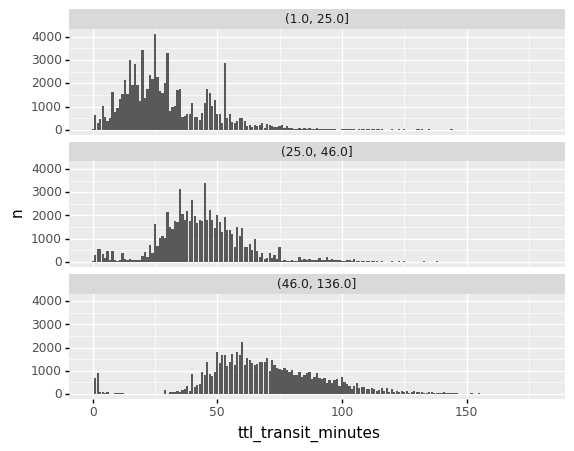

<ggplot: (-9223372036577937541)>

In [16]:
(
    transit_minutes
    >> filter(_.ttl_transit_minutes <= 180, _.ttl_transit_minutes.notna())
    >> collect()
    >> mutate(
        ttl_transit_minutes=_.ttl_transit_minutes.astype(int),
        bin_n_stops=lambda d: pd.qcut(d.stop_sequence_rank, 3, precision=0),
    )
    >> count(_.ttl_transit_minutes, _.bin_n_stops)
    >> ggplot(aes("ttl_transit_minutes", "n"))
    + facet_wrap("~bin_n_stops", ncol=1)
    + geom_col()
)

### Looking at the few trips longer than 3 hours

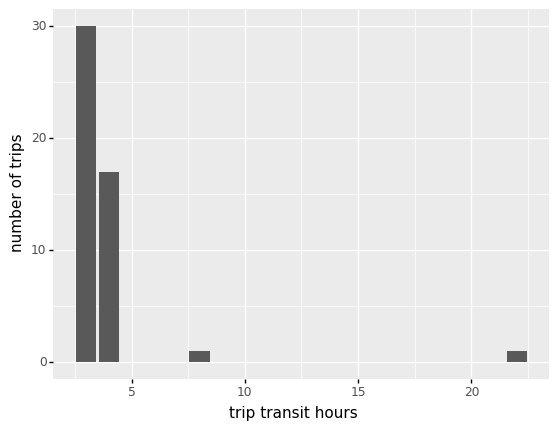

<ggplot: (317957896)>

In [17]:
(
    transit_minutes
    >> filter(_.ttl_transit_minutes > 180)
    >> mutate(ttl_transit_hours=_.ttl_transit_minutes // 60)
    >> collect()
    >> count(_.ttl_transit_hours)
    >> ggplot(aes("ttl_transit_hours", "n"))
    + geom_col()
    + labs(y="number of trips", x="trip transit hours")
)